In [1]:
## Implementing the MLP character level model for words by following this paper  https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf
## This is the first paper introduced for language modelling with MLP. Let's implement this 

print(
"""
Roughly this paper states that finding the next character using the previous n characters. 

For Example: n=3, xs = "abc", ys = "d" 
             n=5, xs = "abcde", ys = "f" 
"""
)



Roughly this paper states that finding the next character using the previous n characters. 

For Example: n=3, xs = "abc", ys = "d" 
             n=5, xs = "abcde", ys = "f" 



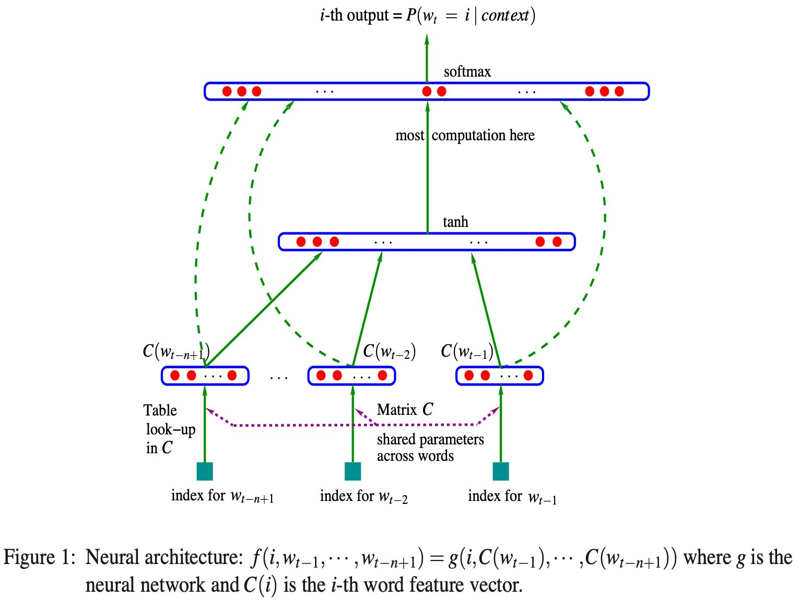

In [2]:
# architecture image 
from PIL import Image 
import urllib

Image.open(urllib.request.urlopen("https://pbs.twimg.com/media/Fhzl42hVUAI9U8V.jpg:large")).resize((800, 600))


# See bottom to top 
## We have 3 layer of input embedding (block size is 3)
## one hidden layer + tanh 
## output layer corresponding to the output size + softamx 

### Note! We are going to implement he neural network based on this architecutre only ;)

In [1]:
import torch 
import torch.nn.functional as F 
import matplotlib.pyplot as plt

In [2]:
## exploring the dataset 
words = open("names.txt", "r").read().splitlines() 

print(f"Len of words: {len(words)}") 
print(f"Words: {words[:10]}")

## Unique characters
chars = sorted(list(set("".join(words)))) 
print(f"Len of unique characters: {len(chars)}") 

## building encoder, decoder like label2id and id2label 
stoi = { v:k+1 for k, v in enumerate(chars)}
stoi['.'] = 0
itos = { v:k for k, v in stoi.items()}
print(f'Itos:\n{itos}')

Len of words: 32033
Words: ['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']
Len of unique characters: 26
Itos:
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# Building the dataset 
block_size = 3  # Total number of previous characters to predict the next character 

X, Y = [], []  # X is the input to the neural net, Y is the output of the corresponding X to the neural net 
for w in words[:5]: 

    context = [0] * block_size  # if n = 3 [0, 0, 0]
    print(w)
    for ch in w + ".": 
        ix = stoi[ch]

        print(context, ix)
        X.append(context)
        Y.append(ix)

        print("".join(itos[i] for i in context), '---->', itos[ix])
        context = context[1:] + [ix]   # it's like rolling window 

    print("---"*5)

## This code tells us how the single word is converting to character level inputs 

X = torch.tensor(X)
Y = torch.tensor(Y)
print("XShape", X.shape, "YShape", Y.shape)

emma
[0, 0, 0] 5
... ----> e
[0, 0, 5] 13
..e ----> m
[0, 5, 13] 13
.em ----> m
[5, 13, 13] 1
emm ----> a
[13, 13, 1] 0
mma ----> .
---------------
olivia
[0, 0, 0] 15
... ----> o
[0, 0, 15] 12
..o ----> l
[0, 15, 12] 9
.ol ----> i
[15, 12, 9] 22
oli ----> v
[12, 9, 22] 9
liv ----> i
[9, 22, 9] 1
ivi ----> a
[22, 9, 1] 0
via ----> .
---------------
ava
[0, 0, 0] 1
... ----> a
[0, 0, 1] 22
..a ----> v
[0, 1, 22] 1
.av ----> a
[1, 22, 1] 0
ava ----> .
---------------
isabella
[0, 0, 0] 9
... ----> i
[0, 0, 9] 19
..i ----> s
[0, 9, 19] 1
.is ----> a
[9, 19, 1] 2
isa ----> b
[19, 1, 2] 5
sab ----> e
[1, 2, 5] 12
abe ----> l
[2, 5, 12] 12
bel ----> l
[5, 12, 12] 1
ell ----> a
[12, 12, 1] 0
lla ----> .
---------------
sophia
[0, 0, 0] 19
... ----> s
[0, 0, 19] 15
..s ----> o
[0, 19, 15] 16
.so ----> p
[19, 15, 16] 8
sop ----> h
[15, 16, 8] 9
oph ----> i
[16, 8, 9] 1
phi ----> a
[8, 9, 1] 0
hia ----> .
---------------
XShape torch.Size([32, 3]) YShape torch.Size([32])


In [6]:
# Now we have created a input data, let's create an embedding to store this inupts and outputs: 
## Here we have 27 unique characters and we are going to embed in low dimensional space. 

### Let's create a two dimensional embeddings (we are initializing randomly)
C = torch.randn( (27, 2) )  # 27 characters and 2 dimensional embeddings 

### Because it's a random number if you want to get the embedding for character "e", just get the index of "e" is 5 and do the indexing in C C[5] value is the
### -- embedding. Later this embeddings will learned by back-propagation. Initially this is just a random numbers. 

# Embedding of character "e"
print(C[stoi["m"]]) 

tensor([1.5654, 1.4854])


In [7]:
## But the pytorch indexing is super powerfull, we can give two dimenional array to indexing, it can index. 
## It means we don't need a for loop to iterate over "X"(input), we can just give the "X" to the tensor and we get all the indexed elements.  

emb = C[X]  # X is the input of the model 
print(emb.shape)

## 32 is row of X or len of unique char, 3 is the block size, 2 is the embedding size.   

torch.Size([32, 3, 2])


In [8]:
## Here we are having 2 dimensional space of embedding and block size of 3 | Each character has 2 dimensional embeddings and we are taking 3 character to find the next character so input is 6 
W1 = torch.randn( (emb[0].numel(), 100))  # emb[0].numel():6 = 3 character(blockSize) * 2 size embeddings, 100 is the next layer neuron 
b1 = torch.randn( 100 )


In [9]:
# our aim is multiply emb@W + b but here the shape of emb and W shape is  different. So we can do matric multiplication between those. 
# emb shape: [32, 3, 2], W shape: [6, 100] both are differnet. 
# We need to change or reshape to do perform matrix mul. 
# In emb shape we try to concatenate last 2 shape [32, 3*2] = [32, 6]. Now we can do matrix multiplication 

## 1st way to do this reshaping 
# To do that we need to take all the embeddings separately and combine them. 
## To separate all the embedding dimension separtely we use "torch.unbind(emb, <dim-to-get-separately>)" 
## to combine all this embedding we use "torch.cat((<list-of-tensor-to-combine>), dim = <which-dim-need-to-concatenate>)"

## 2nd way 
# To do that we can simply call the view function to reshape the embeddings 

## 1st way 
hard = torch.cat(torch.unbind(emb, 1), dim = 1)  ## this is in-efficient way to do that

## 2nd way 
easy = emb.view(-1, emb[0].numel())

# comparing the both
# print(hard == easy)

In [10]:
# Let's do the forward pass 

h = torch.tanh( emb.view(-1, emb[0].numel()) @ W1 + b1) # first hidden layer 

## Let's implement 2nd hidden layer (ouput + softmax)

In [11]:
## second hidden layer 
W2 = torch.randn((100, 27))  # 100 is previous layer size  
b2 = torch.randn(27) 

logits = h@W2 + b2  # log of counts 
counts = logits.exp()
prob = counts /counts.sum(dim=1, keepdim=True) 
loss = -prob[torch.arange(32), Y].log().mean()  # negative log likelihood 
print(f"Negative log likelihood: {loss}")


## we can also do this softmax by using the cross_entropy_function in the pytroch 
print(f"Cross-entropy using F.cross_entropy: {F.cross_entropy(logits, Y)}")

Negative log likelihood: 12.303730010986328
Cross-entropy using F.cross_entropy: 12.303729057312012


In [12]:
""" 
Why F.cross_entropy is good compare to our own implementation ? 

-> First of all it don't create a itermediate tensors, Instead pytorch creates cluster of this operations. 
-> Backword operations is much more easire than our own implementation. 
-> It's more efficient compare to our own implementation. 

    For Example: If the tensor values are [200, 300, 400], applying the exponential function to them results in [-inf, -inf, -inf]
    because as the input values increase, the output approaches higher infinity. This problem is solved in F.cross_entorpy 

    The approach used to solve the problem involves finding the maximum number in the given set and subtracting that maximum value from all
    the elements.
    By doing so, the maximum value becomes 0, and remain values get shifted negative or positive, the problem is then resolved. 
    It is worth noting that while applying the exponential function to numbers below 1 does not pose any issues, higher numbers 
    above 1 can result in certain challenges.

"""

" \nWhy F.cross_entropy is good compare to our own implementation ? \n\n-> First of all it don't create a itermediate tensors, Instead pytorch creates cluster of this operations. \n-> Backword operations is much more easire than our own implementation. \n-> It's more efficient compare to our own implementation. \n\n    For Example: If the tensor values are [200, 300, 400], applying the exponential function to them results in [-inf, -inf, -inf]\n    because as the input values increase, the output approaches higher infinity. This problem is solved in F.cross_entorpy \n\n    The approach used to solve the problem involves finding the maximum number in the given set and subtracting that maximum value from all\n    the elements.\n    By doing so, the maximum value becomes 0, and remain values get shifted negative or positive, the problem is then resolved. \n    It is worth noting that while applying the exponential function to numbers below 1 does not pose any issues, higher numbers \n    

In [13]:
## Let's set everything to the forward pass 

# Building the dataset 
block_size = 3  # Total number of previous characters to predict the next character 

X, Y = [], [] 
for w in words: 
    context = [0] * block_size  
    for ch in w + ".": 
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        context = context[1:] + [ix]   

X = torch.tensor(X)
Y = torch.tensor(Y)

print("XShape", X.shape, "YShape", Y.shape)

# 1. Setting up the paramters 
g = torch.Generator().manual_seed(2147483647)
C = torch.randn( (27, 2) )  # Embedding tensor 
b1 = torch.randn(100, generator=g)
W1 = torch.randn( (6, 100), generator=g)
b2 = torch.randn(27, generator=g)
W2 = torch.randn( (100, 27), generator=g) 

parameters = [C, b1, b2, W1, W2] 

print(f"Total of paramters: {sum(p.nelement() for p in parameters)}")

## making all require grads = True 
for p in parameters:
    p.requires_grad=True 

XShape torch.Size([228146, 3]) YShape torch.Size([228146])
Total of paramters: 3481


In [14]:
# 2. Training loop 

for _ in range(10000): 

    ## forward pass 
    ## Doing forward pass in all the data is very bad, so we take the batch and do the computation 
    ix = torch.randint(0, X.shape[0], (32,) )
    emb = C[X[ix]]  # mini batch
    h = torch.tanh( emb.view(-1, 6)@W1 + b1) 
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Y[ix]) 

    ## backward pass 
    for p in parameters: 
        p.grad = None 
    loss.backward()

    ## update 
    for p in parameters: 
        p.data += -0.001 * p.grad 

# all loss 
ix = torch.randint(0, X.shape[0], (32,) )
emb = C[X]  # mini batch
h = torch.tanh( emb.view(-1, 6)@W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Y)
print(f"Overall loss: {loss}") 

Overall loss: 3.51939058303833


In [15]:
# How do we find the optimial learning rate? 
## One way we can calculate by trying with multiple learning rates and finding the optimal lr. 
## But this is very in-efficient way ;(  
## So, we can create a linear learning array and find the optimal learning rate by looping through all those. 

lre = torch.linspace(-3, 0, 1000)  # 1000 points 
lre = 10**lre  ## search in google for this  


In [16]:
# 2. Training loop with learning rate search 


lri = []
losses = []
for i in range(1000): 

    ## forward pass 
    ## Doing forward pass in all the data is very bad, so we take the batch and do the computation 
    ix = torch.randint(0, X.shape[0], (32,) )
    emb = C[X[ix]]  # mini batch
    h = torch.tanh( emb.view(-1, 6)@W1 + b1) 
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Y[ix]) 

    ## backward pass 
    for p in parameters: 
        p.grad = None 
    loss.backward()

    ## update 
    lr = lre[i]
    for p in parameters: 
        p.data += -lr * p.grad 

    lri.append(lr)
    losses.append(loss.item())

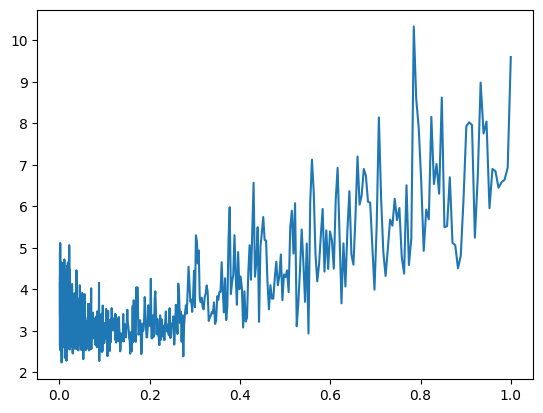

In [17]:
plt.plot(lri, losses); 
# Here we found the learning rate near 0.01 is very good. So, will use this and train a model :) 

In [3]:
## Currently we are overfitting the model because we are giving all the data to model for training. So, let's split the data to train, test and val 
# train is used to train the parameters
# val/dev is used to train the hyper-parameters 
# test is used to evaluvate the performance of the model at the end ;) (only allowded to use this model after train/val otherwise model may learn from this data (data-leakage))

# let's split our data : )

def build_dataset(words): 
    block_size = 3  
    X, Y = [], [] 
    for w in words: 
        context = [0] * block_size  
        for ch in w + ".": 
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]   

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print("XShape", X.shape, "YShape", Y.shape)
    return X, Y 

import random 
random.seed(42)

random.shuffle(words)
n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)


Xtr, Ytr = build_dataset(words[:n1]) 
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


XShape torch.Size([182625, 3]) YShape torch.Size([182625])
XShape torch.Size([22655, 3]) YShape torch.Size([22655])
XShape torch.Size([22866, 3]) YShape torch.Size([22866])


In [4]:
# 1. Setting up the paramters 
g = torch.Generator().manual_seed(2147483647)
C = torch.randn( (27, 2) )  # Embedding tensor 
b1 = torch.randn(100, generator=g)
W1 = torch.randn( (6, 100), generator=g)
b2 = torch.randn(27, generator=g)
W2 = torch.randn( (100, 27), generator=g) 

parameters = [C, b1, b2, W1, W2] 

print(f"Total of paramters: {sum(p.nelement() for p in parameters)}")

## making all require grads = True 
for p in parameters:
    p.requires_grad=True 

Total of paramters: 3481


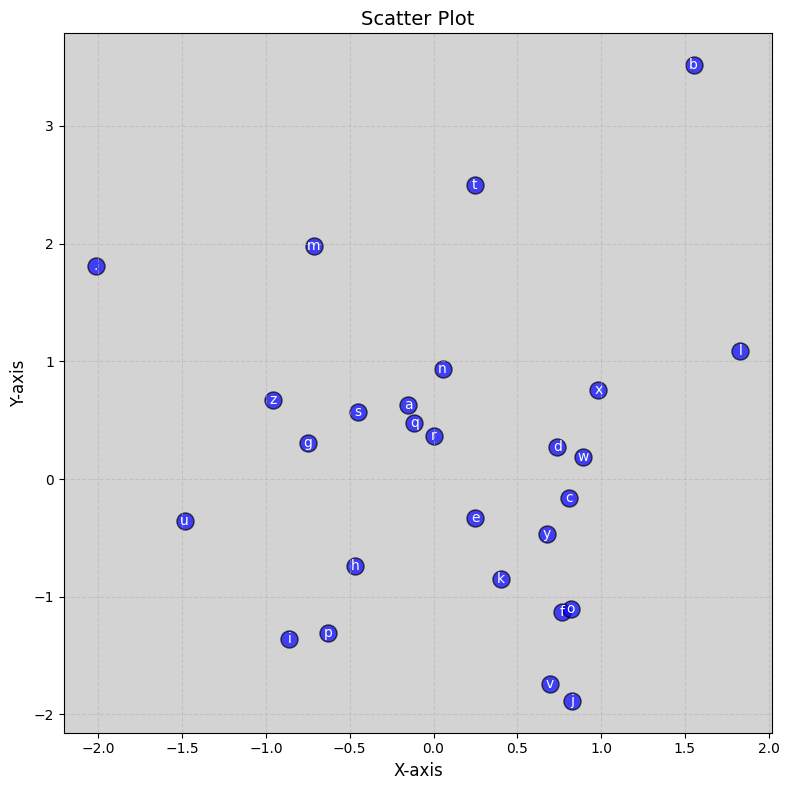

In [5]:
# plotting the embeddings 

plt.figure(figsize=(8, 8))

# Scatter plot
plt.scatter(C[:, 0].data, C[:, 1].data, s=150, c='blue', edgecolors='black', alpha=0.7)

for i in range(C.shape[0]):
    # Text annotations
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha="center", va="center", color="white")

# Axis labels
plt.xlabel("X-axis", fontsize=12)
plt.ylabel("Y-axis", fontsize=12)

# Title
plt.title("Scatter Plot", fontsize=14)

# Gridlines
plt.grid(True, linestyle='--', alpha=0.5)

# Background color
plt.gca().set_facecolor('lightgray')

# Adjust padding
plt.tight_layout()

# Show the plot
plt.show()


In [12]:
# 2. Training loop 
## Here changing the networks to only train with train split
## And evaluvating with dev set 


for _ in range(20000): 

    ## forward pass 
    ## Doing forward pass in all the data is very bad, so we take the batch and do the computation 
    ix = torch.randint(0, Xtr.shape[0], (32,) )
    emb = C[Xtr[ix]]  # mini batch
    h = torch.tanh( emb.view(-1, 6)@W1 + b1) 
    logits = h @ W2 + b2 
    loss = F.cross_entropy(logits, Ytr[ix]) 

    ## backward pass 
    for p in parameters: 
        p.grad = None 
    loss.backward()

    ## update 
    for p in parameters: 
        p.data += -0.001 * p.grad 

# all loss 
ix = torch.randint(0, Xdev.shape[0], (32,) )
emb = C[Xdev]  # evaluvating with dev set 
h = torch.tanh( emb.view(-1, 6)@W1 + b1) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Ydev)
print(f"Overall loss: {loss}") 

Overall loss: 2.318591833114624


In [13]:
# 3. inference 
block_size = 3
for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

meycan.
madhevcoriyo.
sul.
jundy.
ivye.
tailanye.
bronkti.
molssezianah.
shat.
luy.
lan.
keadaf.
tcinynie.
azeeklyn.
doly.
dylin.
jimahtastadakel.
bry.
siranynd.
kaliw.


In [ ]:
## Now we completed the whole architecture of the model and tuned the model according to the model :) 

### Now you need to explore the hyper parameters like changing the hidden layer, batch size, increasing the embedding dimension from 2 to n like 512 



